<a href="https://colab.research.google.com/github/sergiusz28/dw_matrix_road_sign/blob/master/Day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np

import os
import datetime

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from skimage import color, exposure

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
cd '/content/drive/My Drive/Colab Notebooks/dwmatrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/dwmatrix/matrix_three/dw_matrix_road_sign


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

In [32]:
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),

  Flatten(),

  Dense(num_classes, activation='softmax')
])

#model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(x_train, y_train)

1088/1088 [==============================] - 4s 4ms/step - loss: 5.5778 - accuracy: 0.7892


In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),

    Flatten(),

    Dense(num_classes, activation='softmax')
  ])

def train_model(model, x_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%sS'))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
  model.fit(x_train,
            y_train,
            batch_size=params_fit.get('batch_size', 128),
            epochs=params_fit.get('epochs', 5),
            verbose=params_fit.get('verbose', 1),
            validation_data=params_fit.get('validation_data', (x_train, y_train)),
            callbacks= [tensorboard_callback]
            )
  return model

In [34]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, x_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 26.3977 - accuracy: 0.7293 - val_loss: 0.2485 - val_accuracy: 0.9397
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2611 - accuracy: 0.9405 - val_loss: 0.1312 - val_accuracy: 0.9683
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1694 - accuracy: 0.9605 - val_loss: 0.1152 - val_accuracy: 0.9731
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1300 - accuracy: 0.9709 - val_loss: 0.0803 - val_accuracy: 0.9825
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1026 - accuracy: 0.9768 - val_loss: 0.0692 - val_accuracy: 0.9875


In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']


In [0]:
def predict(model_trained, x_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(x_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)


In [51]:
predict(model_trained, x_test, y_test, scoring=accuracy_score)

0.8122448979591836

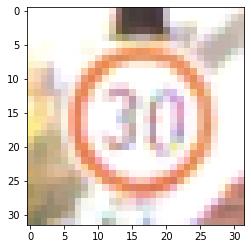

In [37]:
plt.imshow(x_test[400])

In [0]:
def train_and_predict(model):
  model = get_cnn_v2(input_shape, num_classes)
  model_trained = train_model(model, x_train, y_train)
  return predict(model_trained, x_test, y_test, scoring=accuracy_score)

In [55]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
  ])


train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 5.9363 - accuracy: 0.2497 - val_loss: 1.3623 - val_accuracy: 0.6763
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 1.2138 - accuracy: 0.6435 - val_loss: 0.4034 - val_accuracy: 0.9044
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.6111 - accuracy: 0.8180 - val_loss: 0.1838 - val_accuracy: 0.9631
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3845 - accuracy: 0.8850 - val_loss: 0.0873 - val_accuracy: 0.9818
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2874 - accuracy: 0.9143 - val_loss: 0.0592 - val_accuracy: 0.9867


0.9290249433106575

In [56]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
  ])


train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 4.8554 - accuracy: 0.4241 - val_loss: 0.5907 - val_accuracy: 0.8505
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 0.7551 - accuracy: 0.7787 - val_loss: 0.2259 - val_accuracy: 0.9452
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.4605 - accuracy: 0.8638 - val_loss: 0.1145 - val_accuracy: 0.9769
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3264 - accuracy: 0.9043 - val_loss: 0.0926 - val_accuracy: 0.9800
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2683 - accuracy: 0.9214 - val_loss: 0.0546 - val_accuracy: 0.9854


0.9204081632653062

In [59]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same' ),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])


train_and_predict(get_cnn_v4(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 3.5539 - accuracy: 0.5110 - val_loss: 0.4578 - val_accuracy: 0.8981
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 0.5550 - accuracy: 0.8413 - val_loss: 0.1469 - val_accuracy: 0.9720
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.3414 - accuracy: 0.9001 - val_loss: 0.0853 - val_accuracy: 0.9799
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2475 - accuracy: 0.9283 - val_loss: 0.0535 - val_accuracy: 0.9895
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2033 - accuracy: 0.9387 - val_loss: 0.0553 - val_accuracy: 0.9863


0.9297052154195011

In [60]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same' ),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])


train_and_predict(get_cnn_v5(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 7.5230 - accuracy: 0.1612 - val_loss: 2.5911 - val_accuracy: 0.3211
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 1.8796 - accuracy: 0.4736 - val_loss: 0.7892 - val_accuracy: 0.7971
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.9553 - accuracy: 0.7107 - val_loss: 0.4146 - val_accuracy: 0.8993
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.6144 - accuracy: 0.8141 - val_loss: 0.1853 - val_accuracy: 0.9577
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.4032 - accuracy: 0.8799 - val_loss: 0.1071 - val_accuracy: 0.9782


0.8934240362811792